In [1]:
from load_modules import *
from scipy.ndimage import gaussian_filter
import my_config
import time
# conda create --name tf_gpu tensorflow-gpu
# conda activate tf_gpu
# pip install pandas scikit-learn matplotlib colorspacious ipykernel
# pip install opencv-python pandas scikit-learn matplotlib colorspacious 
# os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [3]:
if my_config.USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU')
    #set memory amount to half of GPU
    if len(physical_devices) > 0:
        for device in physical_devices:
            print("Device:", device)
    else:
        print("No GPU devices found.")
    # Set GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
        except RuntimeError as e:
            print(e)
        # Set environment variable for GPU memory allocation

    # Test for GPU device name
    name = tf.test.gpu_device_name()
    if name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(name))
    # Print the number of available GPUs
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU")

No GPU


In [4]:
image_paths = os.listdir(r"models_4k")
base_path = r"models_4k"

all_model_paths = []
print(my_config.IMAGE_FOLDER)
print(my_config.ENCODER_PATH)
print(my_config.DECODER_PATH)

encoder = load_model(r"TrainedModels/316/encoder.h5")
encoder = load_model(r"TrainedModels/no_duplicates_75_2_mask/decoder.h5")

decoder = load_model(r"TrainedModels/316/decoder.h5")
decoder = load_model(r"TrainedModels/no_duplicates_75_2_mask/decoder.h5")
print("Encoder summary:" + str(encoder.summary()))
print("Decoder summary:" + str(decoder.summary()))
def encode(img):
    #make sure image is in correct format 2048x2048x3
    # img = Image.fromarray(img).resize((2048, 2048))
    img = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    # with tf.device('/device:GPU:0'):
    #     pred_maps = encoder.predict_on_batch(image)
    pred_maps = encoder.predict(img)
    #convert to numpy array
    # pred_maps = np.array(pred_maps)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    # with tf.device('/device:GPU:0'):
    #     recovered = decoder.predict_on_batch(encoded)
    recovered = decoder.predict(encoded)

    end = time.time()
    # recovered = np.array(recovered).reshape((2048, 2048, 3))
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed

def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

def age_mel(v, t, r=0.08):
    """
    v is original volume fraction of melanin
    t is number of decades
    r is rate of decline (typical is 8%)
    """
    v_prime = v-(t*r)*v
    return v_prime

def age_hem(v, t, r_Hbi=0.06, r_Hbe=0.1, zeta=0.5):
    """
    v is original volume fraction of hemoglobin
    t is number of decades
    r is rate of decline (typical is 6%)
    """
    v_prime = v-t*(r_Hbi+zeta*r_Hbe)*v
    return v_prime

models_4k
/TrainedModels/316/encoder.h5
/TrainedModels/316/decoder.h5
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 5)]               0         
                                                                 
 decoder_dense_1 (Dense)     (None, 75)                450       
                                                                 
 decoder_dense_2 (Dense)     (None, 75)                5700      
                                                                 
 encoder_output (Dense)      (None, 3)                 228       
                                                                 
Total params: 6,378
Trainable params: 6,378
Non-trainable params: 0
_________________________________________________________________
Encoder summary:None
Model: "decoder"
_________________________________________________________________
 Layer (type)  

In [315]:
image_paths = os.listdir(r"models_4k")
images = []
names = []
for image_path in image_paths:
    folder_name = image_path.split('.')[0]
    names.append(folder_name)
    image_path = os.path.join(my_config.IMAGE_FOLDER, image_path)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if np.max(image) > 1:
        image = image/255.0
    images.append(image)
print(names)
all_model_paths = []
encoder = load_model(r"TrainedModels/316/encoder.h5")
decoder = load_model(r"TrainedModels/316/decoder.h5")
def encode(img):
    image = np.asarray(img).reshape(-1,3)
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    with tf.device('/device:GPU:0'):
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    with tf.device('/device:GPU:0'):
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

['m46_4k', 'metina', 'm64_4k', 'm98_4k', 'm141_4k', 'm53_4k', 'm32']


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


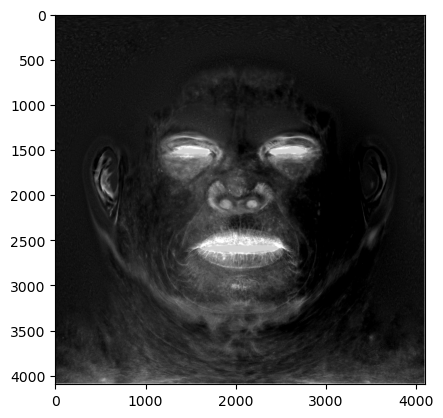

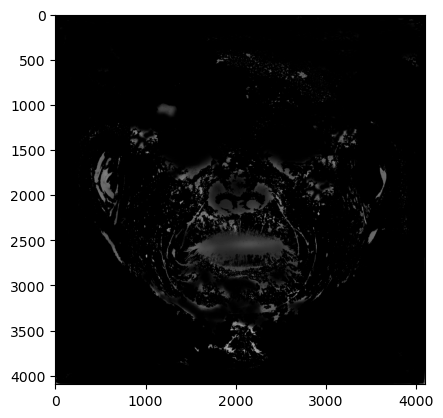

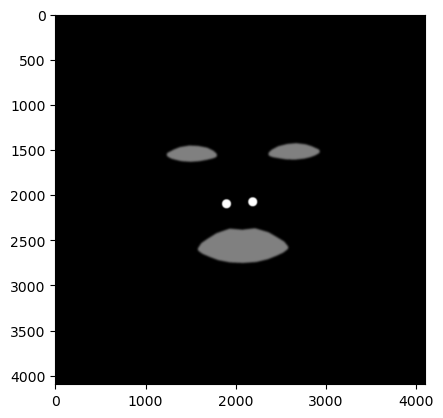

min 0.0 mean 0.018043403064503367 max 0.9529411764705882
min 0.0 mean 0.06512882008272054 max 0.4666666666666667


In [448]:
hem_mask_path = r"sunspots/hem_mask.png"
mel_mask_path = r"sunspots/melmask2.png"
eye_mask_path = r"sunspots/eye_mask.png"
eye_lip_mask_path = r"sunspots/eye_lip_mask.png"



hem_mask = cv2.imread(hem_mask_path, cv2.IMREAD_GRAYSCALE) 
mel_mask = cv2.imread(mel_mask_path, cv2.IMREAD_GRAYSCALE)
eye_lip_mask = cv2.imread(eye_lip_mask_path, cv2.IMREAD_GRAYSCALE)
#expand masked area of eye mask
# eye_lip_mask_path = cv2.dilate(eye_lip_mask_path, np.ones((45, 55), np.uint8), iterations=1)
#shrink masked area of eye mask
# eye_mask = cv2.erode(eye_mask, np.ones((5,5), np.uint8), iterations=4)

#reshape to 4096x4096
hem_mask = cv2.resize(hem_mask, (4096, 4096))/255.0
mel_mask = cv2.resize(mel_mask, (4096, 4096))/255.0
eye_lip_mask = cv2.resize(eye_lip_mask, (4096, 4096))/255.0


mel_mask = np.array(mel_mask)
eye_lip_mask = np.array(eye_lip_mask)
eye_lip_mask = gaussian_filter(eye_lip_mask, sigma=5)
# eye_mask = gaussian_filter(eye_mask, sigma=20)
#add gaussian blur to eye mask
# eye_mask = cv2.GaussianBlur(eye_mask, ksize=5, sigmaX=50, sigmaY=50)
hem_mask = 1 - hem_mask 
mel_mask = 1 - mel_mask
eye_lip_mask = eye_lip_mask
#make eye lip mask bniary

# hem_mask = cv2.bitwise_xor(hem_mask, eye_mask)
# mel_mask = cv2.bitwise_xor(mel_mask, eye_lip_mask)

#clamp 0 to 1

#threshold

plt.imshow(hem_mask, cmap='gray')
plt.show()
plt.imshow(mel_mask, cmap='gray')
plt.show()
plt.imshow(eye_lip_mask, cmap="gray")
plt.show()
print(f"min {np.min(mel_mask)} mean {np.mean(mel_mask)} max {np.max(mel_mask)}")

print(f"min {np.min(hem_mask)} mean {np.mean(hem_mask)} max {np.max(hem_mask)}")

shape of hem_mask: (4096, 4096)
Cm min 0.03346329554915428 mean 0.16528354585170746 max 0.6082751154899597
Cm min 0.03078623116016388 mean 0.1547490358352661 max 0.6993744969367981
Ch min 0.0914304256439209 mean 0.13963480293750763 max 0.2609216570854187
Ch min 0.061258383095264435 mean 0.10128620266914368 max 0.2811811566352844
Bm min 0.4475539028644562 mean 0.46694934368133545 max 0.5535010099411011
Bm min 0.4923093020915985 mean 0.5136440992355347 max 0.6088511347770691
Bh min 0.34195777773857117 mean 0.5367228984832764 max 0.69242262840271
Bh min 0.3351186215877533 mean 0.5259882807731628 max 0.6785742044448853
T min 0.1152021735906601 mean 0.20235851407051086 max 0.23733201622962952
T min 0.11174611002206802 mean 0.19628773629665375 max 0.23021206259727478
shape of recovered: (16777216, 3)


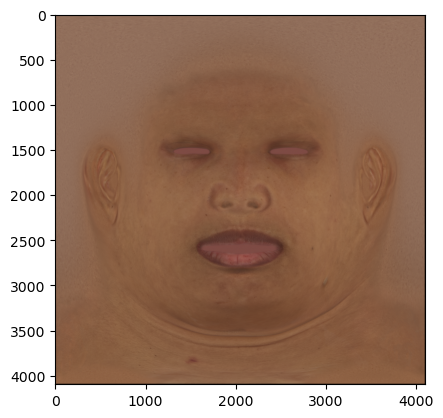

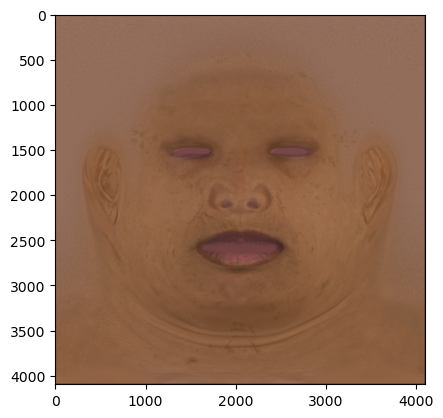

size of image: (4096, 4096, 3)
max pixel value: 0.681401789188385
min pixel value: 0.054967399686574936
m46
Cm min -0.10027988255023956 mean -0.0060667796060442924 max 0.606253981590271
Cm min -0.09225749224424362 mean -0.0028933370485901833 max 0.6993744969367981
Ch min 0.049096010625362396 mean 0.1011892557144165 max 0.2619868516921997
Ch min 0.032894328236579895 mean 0.07541926950216293 max 0.25361958146095276
Bm min 0.4192204475402832 mean 0.4682399332523346 max 0.5342974066734314
Bm min 0.46114251017570496 mean 0.5150644183158875 max 0.5877271890640259
Bh min 0.3339177072048187 mean 0.4745694696903229 max 0.6563203930854797
Bh min 0.32723936438560486 mean 0.4650780260562897 max 0.6431940197944641
T min 0.11884628981351852 mean 0.2304878979921341 max 0.2779921293258667
T min 0.11528090387582779 mean 0.22357319295406342 max 0.2696523666381836
shape of recovered: (16777216, 3)


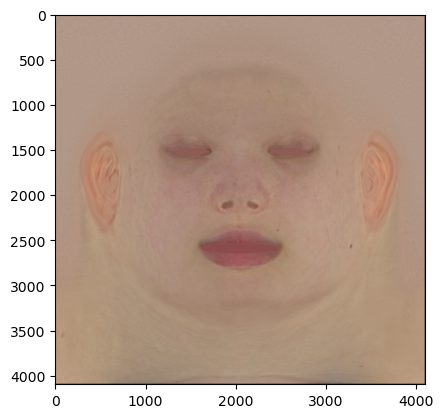

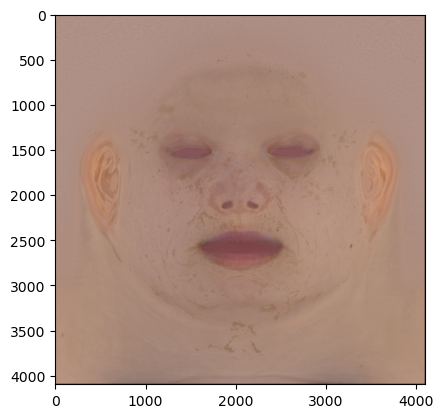

size of image: (4096, 4096, 3)
max pixel value: 0.8213406801223755
min pixel value: 0.06326456367969513
Cm min -0.018970005214214325 mean 0.3336601257324219 max 0.6058624982833862
Cm min -0.017452403903007507 mean 0.30965498089790344 max 0.6993744969367981
Ch min 0.11351731419563293 mean 0.19761061668395996 max 0.27182018756866455
Ch min 0.07684091478586197 mean 0.14027617871761322 max 0.2993941307067871
Bm min 0.45514988899230957 mean 0.5027583241462708 max 0.5416910648345947
Bm min 0.5006648898124695 mean 0.5530344247817993 max 0.5958601832389832
Bh min 0.35368531942367554 mean 0.5085182785987854 max 0.6169816851615906
Bh min 0.3466116189956665 mean 0.4983479082584381 max 0.6046420335769653
T min 0.11884628981351852 mean 0.17639140784740448 max 0.22262898087501526
T min 0.11528090387582779 mean 0.17109942436218262 max 0.2159501165151596
shape of recovered: (16777216, 3)


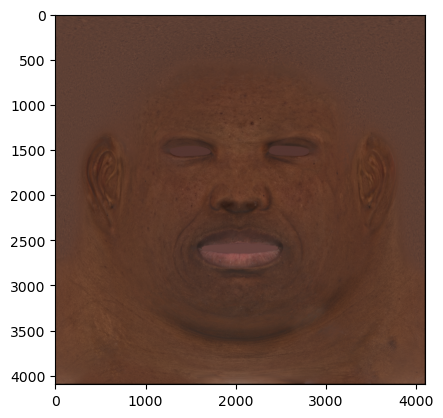

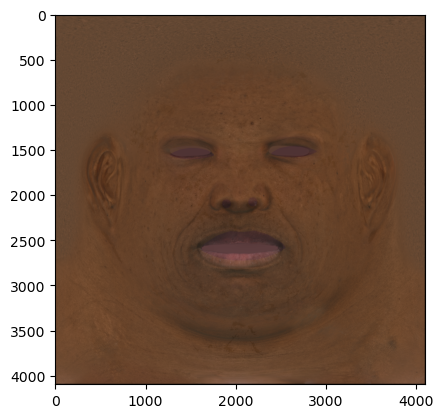

size of image: (4096, 4096, 3)
max pixel value: 0.6473923325538635
min pixel value: 0.05707576870918274
Cm min 0.01697242446243763 mean 0.49287623167037964 max 0.6065470576286316
Cm min 0.015614630654454231 mean 0.4561341106891632 max 0.6993744969367981
Ch min 0.13492955267429352 mean 0.2543758451938629 max 0.2754439115524292
Ch min 0.09295229613780975 mean 0.17853988707065582 max 0.3167581558227539
Bm min 0.4418247938156128 mean 0.5230117440223694 max 0.5455485582351685
Bm min 0.4860072731971741 mean 0.5753134489059448 max 0.6001034379005432
Bh min 0.3323488235473633 mean 0.41791656613349915 max 0.5345054268836975
Bh min 0.32570186257362366 mean 0.40955838561058044 max 0.5238153338432312
T min 0.11794906854629517 mean 0.14623196423053741 max 0.19326446950435638
T min 0.11441060155630112 mean 0.14184480905532837 max 0.1874665468931198
shape of recovered: (16777216, 3)


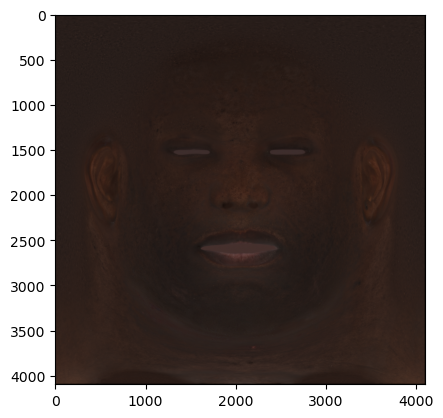

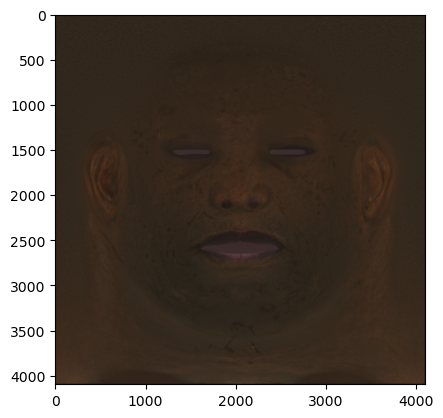

size of image: (4096, 4096, 3)
max pixel value: 0.5622999668121338
min pixel value: 0.059645846486091614
Cm min -0.12033900618553162 mean -0.03945447504520416 max 0.6048188209533691
Cm min -0.11071188747882843 mean -0.03360999375581741 max 0.6993744969367981
Ch min 0.019863311201334 mean 0.07274745404720306 max 0.26485392451286316
Ch min 0.014112493023276329 mean 0.056228239089250565 max 0.23100540041923523
Bm min 0.4372950792312622 mean 0.4672556519508362 max 0.5214961767196655
Bm min 0.4810245931148529 mean 0.5139814019203186 max 0.573645830154419
Bh min 0.35368531942367554 mean 0.4932069182395935 max 0.7057724595069885
Bh min 0.3466116189956665 mean 0.4833427667617798 max 0.6916570067405701
T min 0.11884628981351852 mean 0.25358089804649353 max 0.2948349118232727
T min 0.11528090387582779 mean 0.2459731549024582 max 0.2859898805618286
shape of recovered: (16777216, 3)


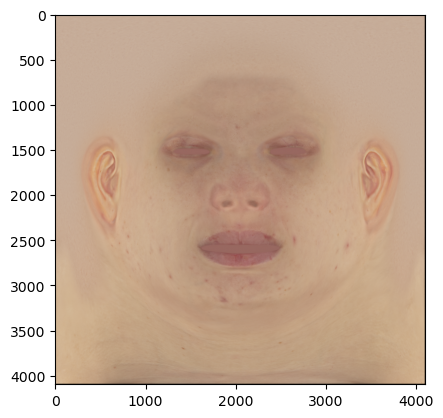

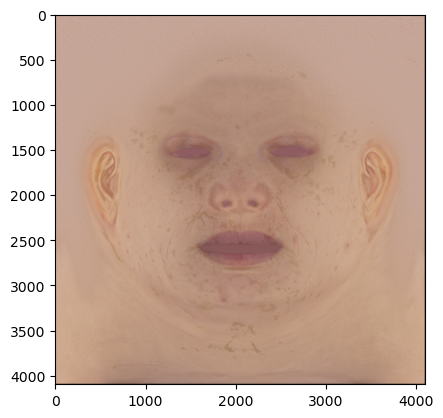

size of image: (4096, 4096, 3)
max pixel value: 0.8636630177497864
min pixel value: 0.06326456367969513
Cm min -0.06582620739936829 mean 0.03668559715151787 max 0.6065470576286316
Cm min -0.060560110956430435 mean 0.036438845098018646 max 0.6993744969367981
Ch min 0.008262667804956436 mean 0.0817338228225708 max 0.25555887818336487
Ch min 0.008778703399002552 mean 0.06229346618056297 max 0.24135535955429077
Bm min 0.4384395480155945 mean 0.4616990387439728 max 0.5287182927131653
Bm min 0.48228350281715393 mean 0.5078692436218262 max 0.5815901160240173
Bh min 0.34930703043937683 mean 0.5480659604072571 max 0.7298310995101929
Bh min 0.34232088923454285 mean 0.5371050238609314 max 0.7152345180511475
T min 0.11766653507947922 mean 0.24845759570598602 max 0.3081355392932892
T min 0.11413653939962387 mean 0.24100378155708313 max 0.29889148473739624
shape of recovered: (16777216, 3)


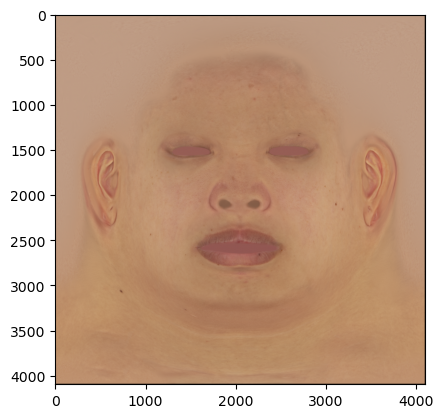

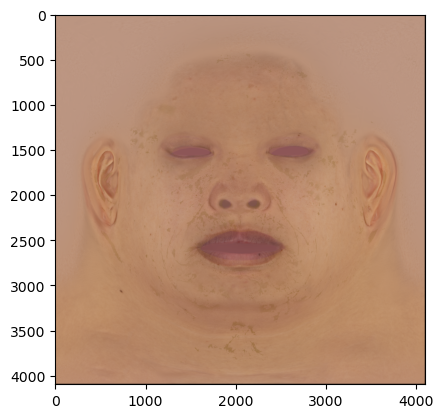

size of image: (4096, 4096, 3)
max pixel value: 0.9019513726234436
min pixel value: 0.06326456367969513
Cm min -0.11354318261146545 mean -0.005631896201521158 max 0.6065470576286316


ValueError: operands could not be broadcast together with shapes (4194304,) (16777216,) 

In [462]:
# fig,ax = plt.subplots(5,5, figsize=(16,14))
subjects_meta = ['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k', 'metina.png']
idx = 0
# hem_mask_path = r"m32_Ch.png"
# mel_mask_path = r"m32_Cm.png"
# hem_mask = cv2.imread(hem_mask_path, cv2.IMREAD_GRAYSCALE)/255.0 
# mel_mask = cv2.imread(mel_mask_path, cv2.IMREAD_GRAYSCALE)/255.0
# hem_mask = np.array(hem_mask)
# mel_mask = np.array(mel_mask)


print(f"shape of hem_mask: {hem_mask.shape}")
#reshape to 4096x4096
# hem_mask = np.resize(hem_mask, (4096,4096))
# mel_mask = np.resize(mel_mask, (4096,4096))
#convert to binary

for image, folder_name in zip(images, names):

    idx += 1
    WIDTH = image.shape[0]
    HEIGHT = image.shape[1]
    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    pred_maps, encode_time = encode(image_numpy)

    #melanin
    print(f"Cm min { np.min(pred_maps[:,0])} mean {np.mean(pred_maps[:,0])} max {np.max(pred_maps[:,0])}")
    pred_maps[:,0] = np.where(eye_lip_mask.reshape(-1)  > 0.7, age_mel(pred_maps[:,0],1), age_mel(pred_maps[:,0],1)+0.15*mel_mask.reshape(-1) )
    # pred_maps[:,0] = np.asarray(age_mel(pred_maps[:,0]-0.2*eye_lip_mask.reshape(-1), 2)+0.1*mel_mask.reshape(-1,))
    print(f"Cm min { np.min(pred_maps[:,0])} mean {np.mean(pred_maps[:,0])} max {np.max(pred_maps[:,0])}")

    #hemoglobin
    print(f"Ch min { np.min(pred_maps[:,1])} mean {np.mean(pred_maps[:,1])} max {np.max(pred_maps[:,1])}")
    # pred_maps[:,1] *= 0.98
    # pred_maps[:,1] = np.asarray(age_hem(pred_maps[:,1], 4))
    pred_maps[:,1] = np.where(eye_lip_mask.reshape(-1)  < 0.5, age_hem(pred_maps[:,1], 3), pred_maps[:,1] )
    pred_maps[:,1] += 0.1*hem_mask.reshape(-1,)
    print(f"Ch min { np.min(pred_maps[:,1])} mean {np.mean(pred_maps[:,1])} max {np.max(pred_maps[:,1])}")

    #melanin blend
    print(f"Bm min { np.min(pred_maps[:,2])} mean {np.mean(pred_maps[:,2])} max {np.max(pred_maps[:,2])}")
    pred_maps[:,2] *= 1.1
    # pred_maps[:,2] += bm_mask.reshape(-1,)*0.02
    print(f"Bm min { np.min(pred_maps[:,2])} mean {np.mean(pred_maps[:,2])} max {np.max(pred_maps[:,2])}")

    #hemoglobin blend
    print(f"Bh min { np.min(pred_maps[:,3])} mean {np.mean(pred_maps[:,3])} max {np.max(pred_maps[:,3])}")
    pred_maps[:,3] *= 0.98
    # pred_maps[:,3] = np.where(eye_lip_mask.reshape(-1)  > 0.5, pred_maps[:,3]*0.95, pred_maps[:,3]*0.99 )
    # pred_maps[:,3] -= 0.1*bh_mask.reshape(-1,)
    # pred_maps[:,3] += 0.2*mel_mask.reshape(-1,)
    print(f"Bh min { np.min(pred_maps[:,3])} mean {np.mean(pred_maps[:,3])} max {np.max(pred_maps[:,3])}")

    #t
    print(f"T min { np.min(pred_maps[:,4])} mean {np.mean(pred_maps[:,4])} max {np.max(pred_maps[:,4])}")
    pred_maps[:,4] *= 0.97
    # pred_maps[:,4] += t_mask.reshape(-1,)*0.02
    print(f"T min { np.min(pred_maps[:,4])} mean {np.mean(pred_maps[:,4])} max {np.max(pred_maps[:,4])}")

    recovered, decode_time = decode(pred_maps)
    print(f"shape of recovered: {recovered.shape}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))

    # recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')
    # recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
    plt.imshow(image)
    plt.show()
    plt.imshow(recovered)
    plt.show()
    #save the image 
    #print size of image
    print(f"size of image: {recovered.shape}")
    #max min pixel values
    print(f"max pixel value: {np.max(recovered)}")
    print(f"min pixel value: {np.min(recovered)}")
    #clamp the values to 0-1
    recovered = np.clip(recovered, 0, 1)
    # if filename contains()"m46":
    if "m46" in folder_name:
        print("m46")
        #save the recovered image
        plt.imsave(f"m46_recovered.png", recovered)
        

        filename = f"{folder_name}_recovered.png"
    # experiment_name = input("Enter experiment name: ")
    # file_NAME = f"{experiment_name}_{subjects_meta[idx]}.png"
    # plt.imsave(file_NAME, recovered)
    idx += 1
    

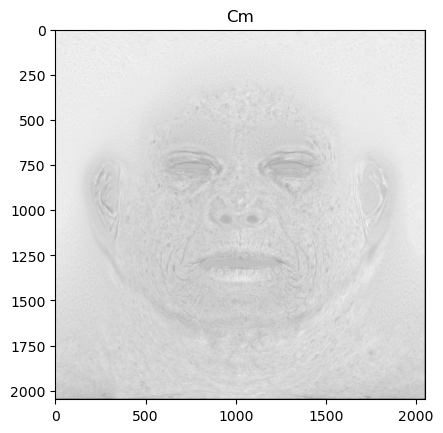

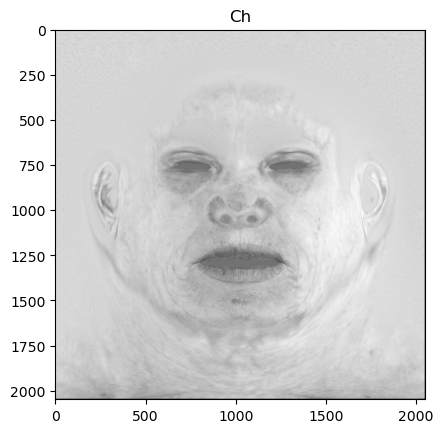

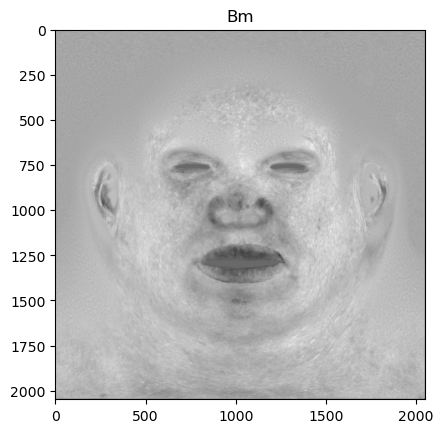

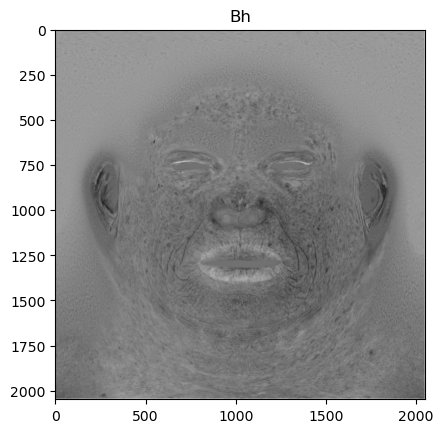

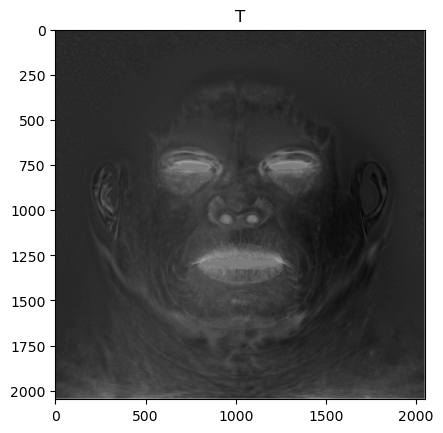

shape of recovered: (4194304, 3)


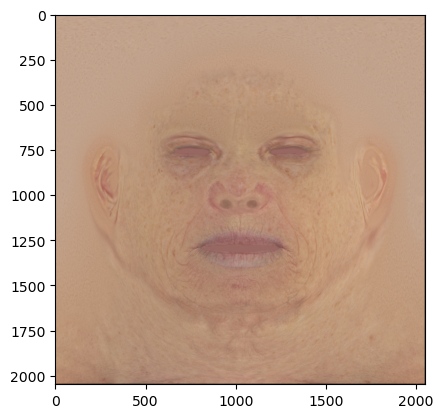

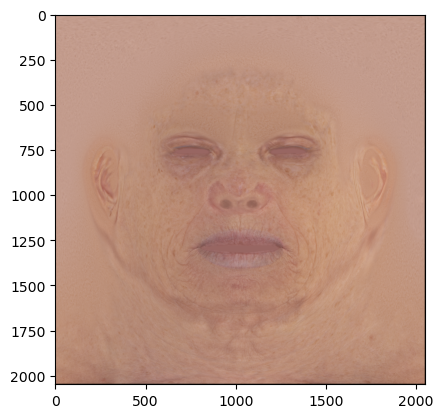

size of image: (2048, 2048, 3)
max pixel value: 0.847469687461853
min pixel value: 0.060189083218574524


In [321]:
image_path = r"models_4k/m32.png"

image = Image.open(image_path).convert('RGB')
image = np.array(image)/255.0

WIDTH = image.shape[0]
HEIGHT = image.shape[1]
image = np.asarray(image)
image_numpy = image.reshape((WIDTH, HEIGHT, 3))
pred_maps, encode_time = encode(image_numpy)

# print(f"min { np.min(pred_maps[:,0])} mean {np.mean(pred_maps[:,0])} max {np.max(pred_maps[:,0])}")
# pred_maps[:,0] = np.asarray(age_mel(pred_maps[:,0], 3)+0.1*mel_mask.reshape(-1,))
# print(f"min { np.min(pred_maps[:,0])} mean {np.mean(pred_maps[:,0])} max {np.max(pred_maps[:,0])}")

# pred_maps[:,1] = np.asarray(age_hem(pred_maps[:,1], 2)+0.025*hem_mask.reshape(-1,))
# # pred_maps[:,0] *= 1.4
# pred_maps[:,1] = np.asarray(pred_maps[:,1])

# pred_maps[:,3] = np.asarray(0.9*age_hem(pred_maps[:,3], 2)+0.025*hem_mask.reshape(-1,))
# pred_maps[:,3] *= 0.98

# pred_maps[:,4] *= 0.98
Cm = pred_maps[:,0].reshape(WIDTH, HEIGHT)
plt.imshow(Cm, cmap='binary')   
plt.title("Cm")
plt.show()
plt.imsave("Cm.png", Cm, cmap='binary')
Ch = pred_maps[:,1].reshape(WIDTH, HEIGHT)
plt.imshow(Ch, cmap='binary')
plt.title("Ch")
plt.show()
plt.imsave("Ch.png", Ch, cmap='binary')
Bm = pred_maps[:,2]
plt.imshow(Bm.reshape(WIDTH, HEIGHT), cmap='binary')
plt.title("Bm")
plt.show()
plt.imsave("Bm.png", Bm.reshape(WIDTH, HEIGHT), cmap='binary')
Bh = pred_maps[:,3]
plt.imshow(Bh.reshape(WIDTH, HEIGHT), cmap='binary')
plt.title("Bh")
plt.show()
plt.imsave("Bh.png", Bh.reshape(WIDTH, HEIGHT), cmap='binary')
T = pred_maps[:,4]
plt.imshow(T.reshape(WIDTH, HEIGHT), cmap='binary')
plt.title("T")
plt.show()
plt.imsave("T.png", T.reshape(WIDTH, HEIGHT), cmap='binary')


recovered, decode_time = decode(pred_maps)
print(f"shape of recovered: {recovered.shape}")
recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))

# recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')
# recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
plt.imshow(image)
plt.show()
plt.imshow(recovered)
plt.show()
#save the image 
#print size of image
print(f"size of image: {recovered.shape}")
#max min pixel values
print(f"max pixel value: {np.max(recovered)}")
print(f"min pixel value: {np.min(recovered)}")
#clamp the values to 0-1
recovered = np.clip(recovered, 0, 1)
# experiment_name = input("Enter experiment name: ")
# file_NAME = f"{experiment_name}_{subjects_meta[idx]}.png"
# plt.imsave(file_NAME, recovered)

    

40_anger.png 39_neutral.png


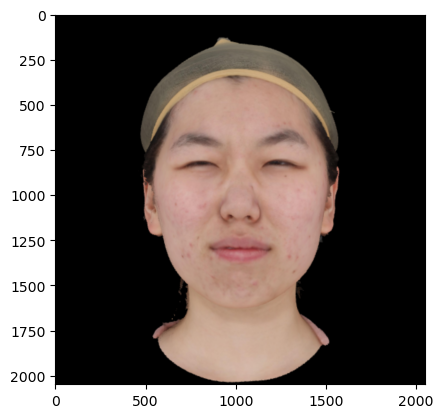

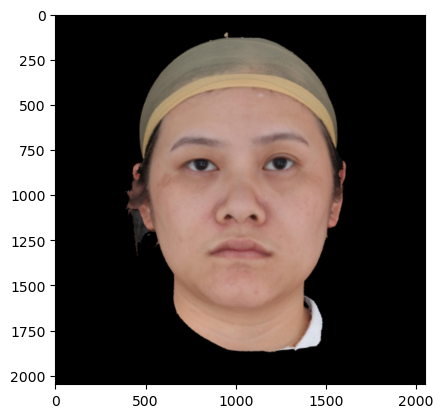

42_anger.png 40_neutral.png


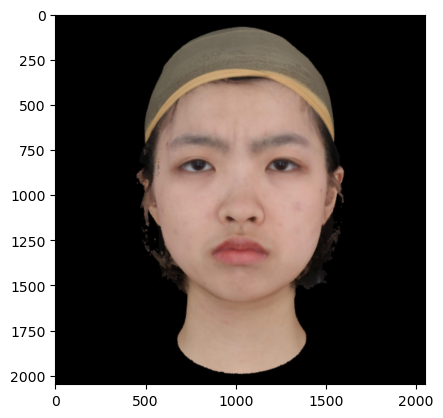

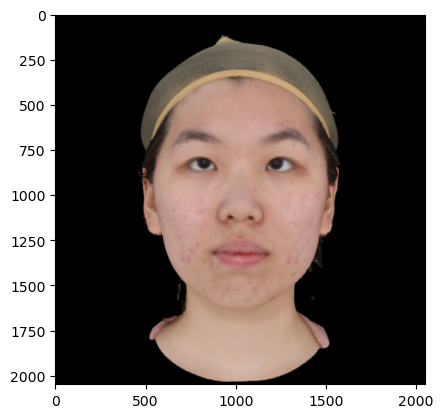

14_anger.png 43_neutral.png


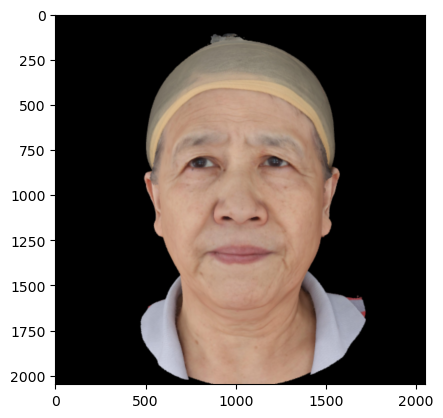

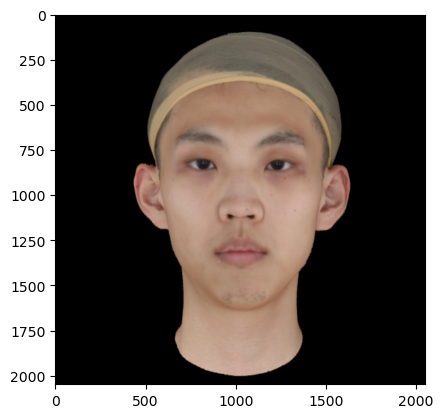

39_anger.png 14_neutral.png


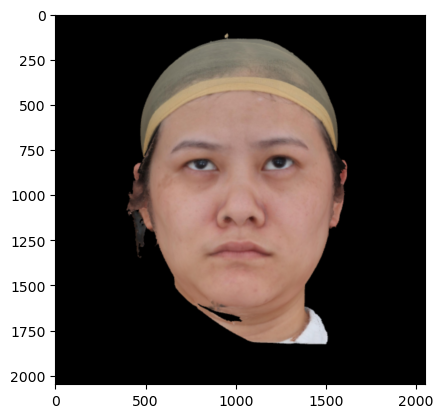

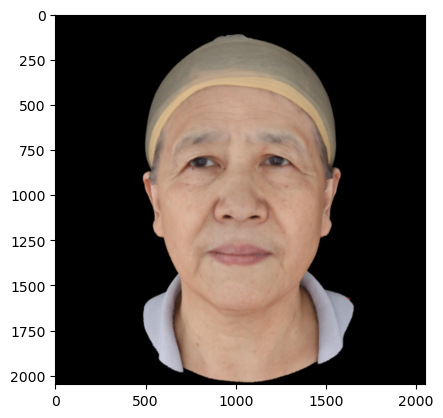

43_anger.png 15_neutral.png


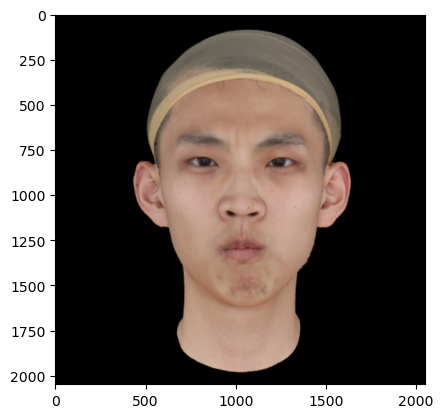

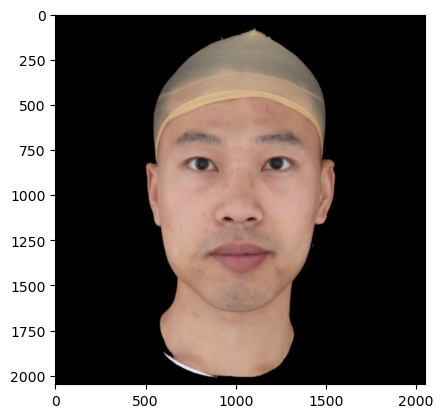

15_anger.png 42_neutral.png


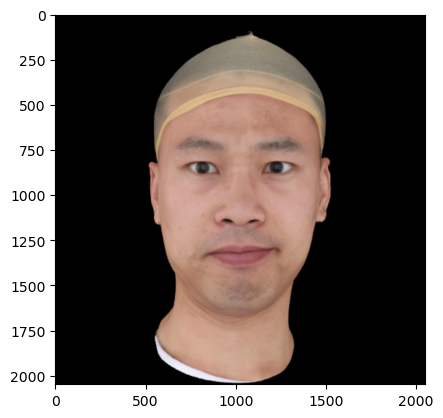

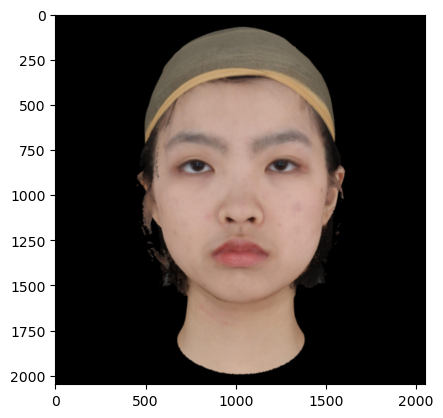

In [7]:
anger_directory = r"emotions/anger"
neutral_directory = r"emotions/neutral"
anger_files = os.listdir(anger_directory)
neutral_files = os.listdir(neutral_directory)
WIDTH = HEIGHT = 2048
for anger, neutral in zip(anger_files, neutral_files):
    print(anger, neutral)
    anger = os.path.join(anger_directory, anger)
    neutral = os.path.join(neutral_directory, neutral)
    #load image
    img_anger = cv2.imread(anger, cv2.IMREAD_COLOR)
    img_neutral = cv2.imread(neutral, cv2.IMREAD_COLOR)
    #convert image to RGB
    img_anger = cv2.cvtColor(img_anger, cv2.COLOR_BGR2RGB)
    img_neutral = cv2.cvtColor(img_neutral, cv2.COLOR_BGR2RGB)
    
    #resize image
    img_anger = cv2.resize(img_anger, (WIDTH, HEIGHT))
    img_neutral = cv2.resize(img_neutral, (WIDTH, HEIGHT))
    #convert image to array
    img_anger = np.array(img_anger)
    img_neutral = np.array(img_neutral)
    #reshape image
    plt.imshow(img_anger)
    plt.show()
    plt.imshow(img_neutral)
    plt.show()


